In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

from PIL import Image

In [3]:
!wget -O dog.jpeg https://cdn.pixabay.com/photo/2016/12/13/05/15/puppy-1903313_960_720.jpg

original_image = Image.open('./dog.jpeg')

--2020-05-11 19:49:36--  https://cdn.pixabay.com/photo/2016/12/13/05/15/puppy-1903313_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.20.183, 104.18.21.183
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.20.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85628 (84K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>]  83.62K  --.-KB/s    in 0.01s   

2020-05-11 19:49:37 (6.38 MB/s) - ‘dog.jpeg’ saved [85628/85628]



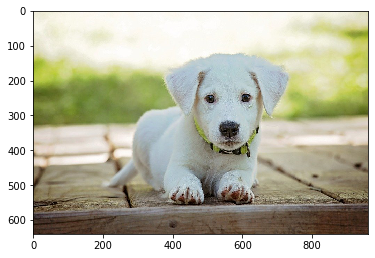

In [4]:
plt.figure(figsize=(6, 6))
plt.imshow(original_image)
plt.show()

### Format Image

In [5]:
IMAGE_SIZE = (224, 224)
img = original_image.resize(IMAGE_SIZE)
img = np.array(img) / 255.0

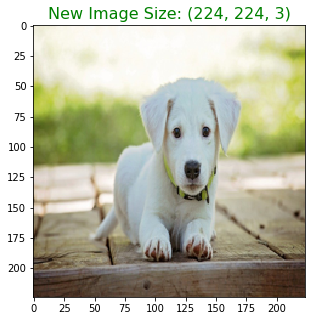

In [6]:
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.title(f"New Image Size: {img.shape}", fontdict={'size': 16}, color='green')
plt.show()

### Get ImageNet Labels

In [7]:
!wget -O labels.txt --quiet https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt

In [8]:
with open('labels.txt', 'r') as f:
    labels = [l.strip() for l in f.readlines()]
    
num_classes = len(labels)
print(f"There are a total of {num_classes} labels representing {num_classes} classes")

There are a total of 1001 labels representing 1001 classes


In [9]:
for label in labels[0:10]:
    print(label)

background
tench
goldfish
great white shark
tiger shark
hammerhead
electric ray
stingray
cock
hen


### Loading a TF Hub Module

In [10]:
MODULE_HANDLE = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4'
module = hub.load(MODULE_HANDLE)

### Performance Inference

In [14]:
predictions = tf.nn.softmax(module([img]))[0]

top_k_pred_values, top_k_indices = tf.math.top_k(predictions, k=5)

top_k_pred_values = top_k_pred_values.numpy()
top_k_indices = top_k_indices.numpy()

for value, i in zip(top_k_pred_values, top_k_indices):
    print(f"{labels[i]}: \t\t{value}")

Labrador retriever: 		0.42202168703079224
Great Pyrenees: 		0.065767802298069
kuvasz: 		0.06191584840416908
tennis ball: 		0.04844116419553757
Old English sheepdog: 		0.028872957453131676


## Using a TF Hub Module with Keras

In [15]:
model = tf.keras.Sequential([
    hub.KerasLayer(MODULE_HANDLE, input_shape=IMAGE_SIZE + (3,)),
    tf.keras.layers.Activation('softmax')
])

In [16]:
img_arr = np.expand_dims(img, axis=0)

In [17]:
predictions = model.predict(img_arr)[0]

top_k_pred_values, top_k_indices = tf.math.top_k(predictions, k=5)

top_k_pred_values = top_k_pred_values.numpy()
top_k_indices = top_k_indices.numpy()

for value, i in zip(top_k_pred_values, top_k_indices):
    print(f"{labels[i]}: \t\t{value}")

Labrador retriever: 		0.42202168703079224
Great Pyrenees: 		0.065767802298069
kuvasz: 		0.06191584840416908
tennis ball: 		0.04844116419553757
Old English sheepdog: 		0.028872957453131676


### Using Feature Vectors with Keras

In [18]:
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"


In [19]:
NUM_CLASSES = 20

model = tf.keras.Sequential([
        hub.KerasLayer(MODULE_HANDLE,
                       input_shape=IMAGE_SIZE + (3,)),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [20]:
MODULE_HANDLE = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4?tf-hub-format=compressed'
!wget -O ./saved_model.tar.gz $MODULE_HANDLE

--2020-05-11 20:33:59--  https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4?tf-hub-format=compressed
Resolving tfhub.dev (tfhub.dev)... 216.58.197.46
Connecting to tfhub.dev (tfhub.dev)|216.58.197.46|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://storage.googleapis.com/tfhub-modules/google/tf2-preview/mobilenet_v2/classification/4.tar.gz [following]
--2020-05-11 20:34:00--  https://storage.googleapis.com/tfhub-modules/google/tf2-preview/mobilenet_v2/classification/4.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.163.48
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.163.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13256595 (13M) [application/x-tar]
Saving to: ‘./saved_model.tar.gz’

./saved_model.tar.g 100%[===================>]  12.64M  8.62MB/s    in 1.5s    

2020-05-11 20:34:02 (8.62 MB/s) - ‘./saved_model.tar.gz’ saved [13256595/13256595]



In [22]:
# Untar the tarball
!mkdir -p ./saved_model
!tar xvzf ./saved_model.tar.gz -C ./saved_model

x ./
x ./assets/
x ./saved_model.pb
x ./variables/
x ./variables/variables.index
x ./variables/variables.data-00000-of-00001


In [23]:
### Running a TF Hub Module Locally

In [24]:
module = hub.load('./saved_model/')

In [25]:
predictions = tf.nn.softmax(module([img]))[0]

top_k_pred_values, top_k_indices = tf.math.top_k(predictions, k=5)

top_k_pred_values = top_k_pred_values.numpy()
top_k_indices = top_k_indices.numpy()

for value, i in zip(top_k_pred_values, top_k_indices):
    print('{}: {:.3}'.format(labels[i], value))

Labrador retriever: 0.422
Great Pyrenees: 0.0658
kuvasz: 0.0619
tennis ball: 0.0484
Old English sheepdog: 0.0289


### Changing the Download Location of TF Hub Modules

In [26]:
new_dir = './hub_cache_dir'
os.environ['TFHUB_CACHE_DIR'] = new_dir

In [27]:
MODULE_HANDLE = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4'
module = hub.load(MODULE_HANDLE)

In [28]:
!ls -R {new_dir}

426589ad685896ab7954855255a52db3442cb38d
426589ad685896ab7954855255a52db3442cb38d.descriptor.txt

./hub_cache_dir/426589ad685896ab7954855255a52db3442cb38d:
assets         saved_model.pb variables

./hub_cache_dir/426589ad685896ab7954855255a52db3442cb38d/assets:

./hub_cache_dir/426589ad685896ab7954855255a52db3442cb38d/variables:
variables.data-00000-of-00001 variables.index
